# Vaccination Rates and Socioeconomic Status in BC

### Project authors:

### Created on: October 25, 2021

### Last modified on: October 25, 2021

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
import scipy as sp
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import ResidualsPlot

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
# load dataframes
modelling_df = pd.read_csv('../data/socioeco_compiled.csv')
vaccine_df = pd.read_csv('../data/BCCDC_COVID19_CHSA_Data_NHA.csv')

In [27]:
# subset dataframes
modelling_df = modelling_df[['code','percent_dwellings_need_repairs','percent_detached_houses',
'situational_vulnerability', 'ethnocultural_composition', 'economic_dependency', 'residential_instability', 
'percent_aboriginal', 'percent_chinese', 'percent_filipino', 'percent_white',
'percent_immigrant', 'percent_no_eng_fra', 'percent_less_than_high_school', 'employment_rate', 'low_income_prevalence',
'percent_postsecondary', 'proportion_has_GP_practice','avg_household_size','hsa']]
vaccine_df = vaccine_df[['CHSA18_Code','D1_12_coverage']]
vaccine_df.columns = ['code', 'D1_12_coverage']

# merge dataframes
m_df = pd.merge(modelling_df, vaccine_df, how = 'inner', on="code")
print(len(m_df))
m_df.head()

151


,code,percent_dwellings_need_repairs,percent_detached_houses,situational_vulnerability,ethnocultural_composition,economic_dependency,residential_instability,percent_aboriginal,percent_chinese,percent_filipino,...,percent_immigrant,percent_no_eng_fra,percent_less_than_high_school,employment_rate,low_income_prevalence,percent_postsecondary,proportion_has_GP_practice,avg_household_size,hsa,D1_12_coverage
0,3112,5.4%,60.7%,3.0,5.0,4.0,2.0,0.6%,65.4%,4.2%,...,65.4%,13.3%,13.0%,49.5%,24.5%,55.9%,79.7%,3.0,Vancouver Coastal Health,84.0
1,3223,10.6%,8.5%,4.0,4.0,1.0,5.0,7.8%,13.4%,3.0%,...,26.6%,4.3%,14.0%,69.9%,20.5%,62.6%,74.5%,1.9,Vancouver Coastal Health,89.0
2,3115,4.6%,48.7%,2.0,5.0,3.0,2.0,1.6%,30.9%,5.3%,...,40.4%,4.4%,10.4%,60.0%,12.4%,62.3%,83.9%,2.6,Vancouver Coastal Health,90.0
3,3261,7.2%,16.4%,4.0,5.0,3.0,4.0,1.5%,40.2%,8.9%,...,52.2%,9.1%,16.6%,59.2%,17.1%,54.3%,80.5%,2.7,Vancouver Coastal Health,92.0
4,3312,6.2%,6.3%,2.0,5.0,1.0,5.0,3.8%,4.2%,6.6%,...,41.4%,1.8%,8.5%,65.8%,18.7%,67.7%,75.0%,2.0,Vancouver Coastal Health,91.0


In [28]:
# remove percent signs
m_df = m_df.replace({'%':''}, regex = True)
m_df = m_df.drop(['code'], axis = 1)
# one hot encode hsa
one_hot = pd.get_dummies(m_df['hsa'])
m_df = m_df.drop('hsa', axis = 1)
m_df = m_df.join(one_hot)


In [29]:
m_df.isna().sum()

percent_dwellings_need_repairs    0
percent_detached_houses           0
situational_vulnerability         3
ethnocultural_composition         3
economic_dependency               3
residential_instability           3
percent_aboriginal                0
percent_chinese                   0
percent_filipino                  0
percent_white                     0
percent_immigrant                 0
percent_no_eng_fra                0
percent_less_than_high_school     0
employment_rate                   0
low_income_prevalence             0
percent_postsecondary             0
proportion_has_GP_practice        0
avg_household_size                0
D1_12_coverage                    0
Fraser Health                     0
Interior Health                   0
Island Health                     0
Northern Health                   0
Vancouver Coastal Health          0
dtype: int64

In [30]:
# remove rows with NAs
m_df = m_df.dropna()

X = m_df.drop(columns=['D1_12_coverage']).values
# X = m_df.iloc[:, :-1].values
y = m_df.iloc[:, -6].values
# normalize the data
trans = MinMaxScaler()
X = trans.fit_transform(X)

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


R2 value = 0.5200599652490325
Feature: 0, Score: 1.75389
Feature: 1, Score: -7.29655
Feature: 2, Score: 1.75316
Feature: 3, Score: -3.08347
Feature: 4, Score: -1.56185
Feature: 5, Score: -2.45892
Feature: 6, Score: -3.89485
Feature: 7, Score: -17.46135
Feature: 8, Score: -1.73557
Feature: 9, Score: -22.80055
Feature: 10, Score: -8.08720
Feature: 11, Score: 10.38860
Feature: 12, Score: -26.71906
Feature: 13, Score: -6.37368
Feature: 14, Score: -7.98160
Feature: 15, Score: -1.09668
Feature: 16, Score: 5.99494
Feature: 17, Score: -2.06036
Feature: 18, Score: 0.89312
Feature: 19, Score: -0.68298
Feature: 20, Score: 4.46442
Feature: 21, Score: -6.06845
Feature: 22, Score: 1.39389


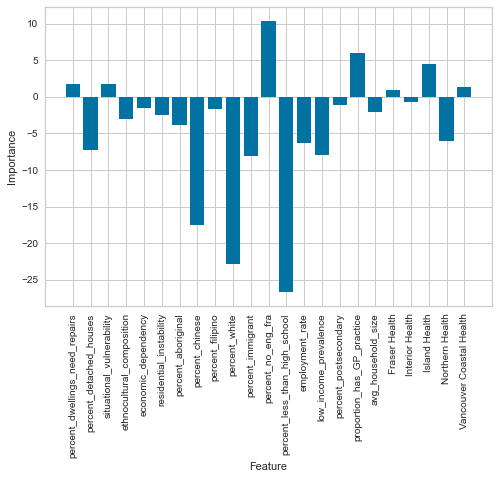

In [44]:
r2 = r2_score(y_test, y_pred)
print(f'R2 value = {r2}')
# get importance
importance = regressor.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = list(m_df.drop(columns=['D1_12_coverage']).columns)
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

So the biggest driver of this model is health authority, with Northern Health being the most strongly correlated.

Let's drop the health authority columns - they're a proxy for other factors.

In [32]:
X = m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health']).values
X = trans.fit_transform(X)
y = m_df.iloc[:, -6].values


# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)
y_pred = regressor2.predict(X_test)

R2 value = 0.5200599652490325
Feature: 0, Score: -0.80641
Feature: 1, Score: -10.97715
Feature: 2, Score: 1.88774
Feature: 3, Score: -1.78056
Feature: 4, Score: 2.52625
Feature: 5, Score: -2.87326
Feature: 6, Score: -8.44602
Feature: 7, Score: -20.64929
Feature: 8, Score: 2.51353
Feature: 9, Score: -17.15501
Feature: 10, Score: -12.57890
Feature: 11, Score: 16.07548
Feature: 12, Score: -29.00877
Feature: 13, Score: -6.49273
Feature: 14, Score: -5.17490
Feature: 15, Score: 3.73598
Feature: 16, Score: 6.13500
Feature: 17, Score: 3.14642


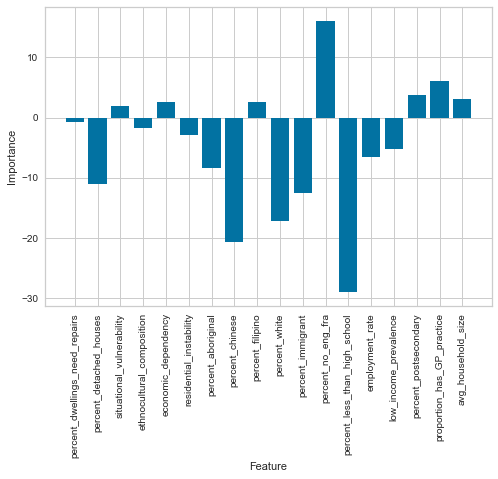

In [45]:
r2 = r2_score(y_test, y_pred)
print(f'R2 value = {r2}')
# get importance
importance = regressor2.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = list(m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 'Vancouver Coastal Health']).columns)
plt.clf()
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

That's an even better R2 score. Let's drop all columns with a score of <|3|.

In [34]:
print(m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 
'Vancouver Coastal Health', 'percent_dwellings_need_repairs','situational_vulnerability', 'ethnocultural_composition',
'percent_filipino']).columns)

Index(['percent_detached_houses', 'economic_dependency',
       'residential_instability', 'percent_aboriginal', 'percent_chinese',
       'percent_white', 'percent_immigrant', 'percent_no_eng_fra',
       'percent_less_than_high_school', 'employment_rate',
       'low_income_prevalence', 'percent_postsecondary',
       'proportion_has_GP_practice', 'avg_household_size'],
      dtype='object')


In [36]:
X = m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 
'Vancouver Coastal Health', 'percent_dwellings_need_repairs','situational_vulnerability', 'ethnocultural_composition',
'percent_filipino']).values
X = trans.fit_transform(X)
y = m_df.iloc[:, -6].values


# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor3 = LinearRegression()
regressor3.fit(X_train, y_train)
y_pred = regressor3.predict(X_test)

R2 value = 0.5200599652490325
Feature: 0, Score: -10.14285
Feature: 1, Score: 2.06933
Feature: 2, Score: -2.87299
Feature: 3, Score: -8.75546
Feature: 4, Score: -19.37044
Feature: 5, Score: -18.79394
Feature: 6, Score: -14.13306
Feature: 7, Score: 15.69736
Feature: 8, Score: -26.09090
Feature: 9, Score: -7.03898
Feature: 10, Score: -5.89465
Feature: 11, Score: 3.78699
Feature: 12, Score: 6.61397
Feature: 13, Score: 1.24821


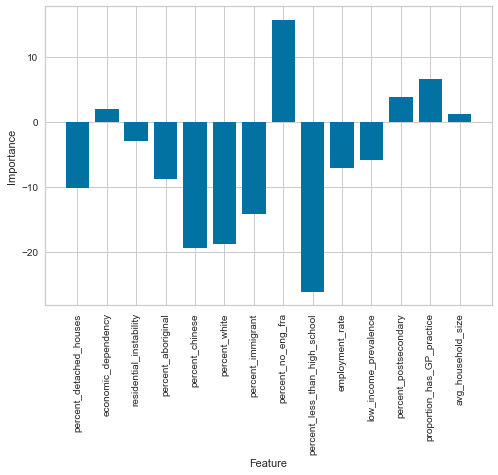

In [46]:
r2 = r2_score(y_test, y_pred)
print(f'R2 value = {r2}')
# get importance
importance = regressor3.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = list(m_df.drop(columns=['D1_12_coverage', 'Fraser Health', 'Interior Health', 'Northern Health', 'Island Health', 
'Vancouver Coastal Health', 'percent_dwellings_need_repairs','situational_vulnerability', 'ethnocultural_composition',
'percent_filipino']).columns)
plt.clf()
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

Let's try keeping only the features with a score >|10|.

In [48]:
X = m_df.iloc[:, m_df.columns.isin(list(['percent_detached_houses', 'percent_chinese', 'percent_white', 'percent_immigrant',
'percent_no_eng_fra', 'percent_less_than_high_school']))].values
X = trans.fit_transform(X)
y = m_df.iloc[:, -6].values


R2 value = 0.5265288678976612
Feature: 0, Score: -1.62677
Feature: 1, Score: -22.57387
Feature: 2, Score: -0.64467
Feature: 3, Score: 8.04521
Feature: 4, Score: 21.42309
Feature: 5, Score: -28.23371


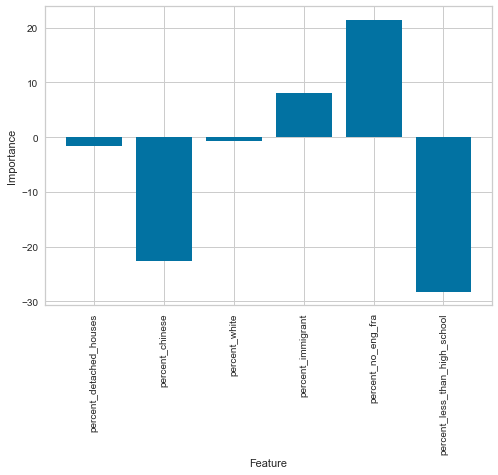

In [49]:
# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor4 = LinearRegression()
regressor4.fit(X_train, y_train)
y_pred = regressor4.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 value = {r2}')
# get importance
importance = regressor4.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = ['percent_detached_houses', 'percent_chinese', 'percent_white', 'percent_immigrant',
'percent_no_eng_fra', 'percent_less_than_high_school']
plt.clf()
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

This 6-variable model has a slightly reduced R2 value, but variation is explained by 4 variables.

In [50]:
X = m_df.iloc[:, m_df.columns.isin(list(['percent_chinese', 'percent_immigrant',
'percent_no_eng_fra', 'percent_less_than_high_school']))].values
X = trans.fit_transform(X)
y = m_df.iloc[:, -6].values

R2 value = 0.5200599652490325
Feature: 0, Score: -23.35934
Feature: 1, Score: 9.05170
Feature: 2, Score: 22.65841
Feature: 3, Score: -28.90342


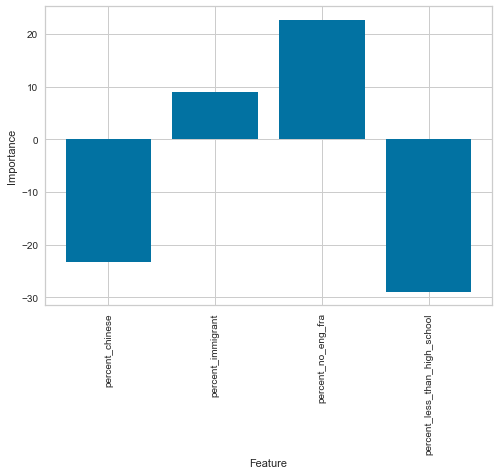

In [51]:
# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
# instantiate the regressor and train
regressor4 = LinearRegression()
regressor4.fit(X_train, y_train)
y_pred = regressor4.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 value = {r2}')
# get importance
importance = regressor4.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
labels = ['percent_chinese', 'percent_immigrant',
'percent_no_eng_fra', 'percent_less_than_high_school']
plt.clf()
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], labels, rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

This 4-variable model has an R2 value of about 0.52. Let's plot residuals.

0.5200599652490325

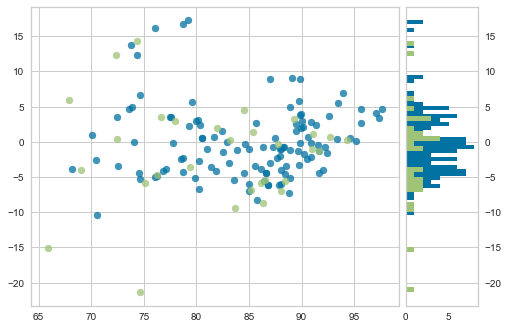

In [43]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.show()                 # Finalize and render the figure

The residuals look pretty evenly distributed.

In [51]:
X = m_df.iloc[:, m_df.columns.isin(list(['percent_no_eng_fra', 
'percent_less_than_high_school']))].values
y = m_df.iloc[:, -1].values